# Linear Regression with Time Series

## Contributers: Priyanka Durai, Alex Dieter, Wendy Zhu & Benjamin Hurt

This notebook introduces linear regression with time series using the ` store sales dataset from Kaggle. 

We will:

* Explain the basic logic behind time series
* Load the store sales dataset
* Add features representing day of the week, time-step and lag 
* Fit and test a linear regression model

This notebook is intended for students who have a basic understanding of Python and linear regression, but no prior experience with time series.

## Time Series

A time series is simply a dataset of sequential observations measured at successive points in time. Unlike most datasets where each row is taken to be independent, time series data is ordered (each observation often influences the ones after it). This component of dependence differentiates time series analysis from simple regression problems.

Our store sales data is a great example, because yesterday's sales will help explain today's.

### Connection to regression 

We can understand time series as examining a trend over time. If we treat time as a numerical predictor, we are able to apply linear regression. 

There are limitations to this due to a violation in linear regression's independence assumption, but we attempt to reconcile that with techniques such as adding lag features.

Our first step towards fitting a linear regression with time series modeling will be setting up our workspace with the appropriate packages, loading in the needed data, and pre-processing it.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}

store_sales = pd.read_csv(
    'data/train.csv',
    dtype=dtype,
    parse_dates=['date']
)

# Set date as index
store_sales = store_sales.set_index('date').to_period('D')

# Set up multi-index: store, family
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)

# Average across stores/families for each date
average_sales = store_sales.groupby('date').mean()['sales']

## Lag Features

A lag feature is a copy of a variable from a previous time step.

This essentially gives our model "memory" of what happened before, and serve as predictors that help the model learn how current data is impacted by past data. This is especially important because linear regression models inherently assume that observations are independent.

### Combine features (time + lag + day of the week)

When we combine the time-step feature, the lag-1 feature, and the day-of-week indicators into a single model, the goal is to capture multiple patterns in the data at the same time. Each feature represents a different source of information about how sales behave. The time feature models long-term trends, such as the gradual increase in average sales over the years. The lag-1 feature brings in short-term memory by telling the model what happened yesterday, which helps predict what will happen today when sales tend to move smoothly from day to day. The day-of-week features capture weekly patterns, such as weekends having different sales behavior compared to weekdays. By combining all of these features into one regression model, we allow the model to learn the trend, the recent past, and the weekly seasonality at the same time. This usually improves accuracy compared to using any single feature alone, because real time-series data is influenced by multiple patterns simultaneously.

In [3]:
df = average_sales.to_frame()

# Time index
df['time'] = np.arange(len(df))

# Lag-1 feature
df['lag_1'] = df['sales'].shift(1)

# Day of week feature
df['dow'] = df.index.to_timestamp().dayofweek
dow_dummies = pd.get_dummies(df['dow'], prefix='dow', drop_first=True)
df = pd.concat([df, dow_dummies], axis=1)

# Drop NA from lag
df = df.dropna()

# Normal 80/20 test/train split
split_point = int(len(df) * 0.8)
train_df = df.iloc[:split_point]
test_df = df.iloc[split_point:]

In [4]:
X_train = train_df.drop(columns=['sales'])
y_train = train_df['sales']

X_test = test_df.drop(columns=['sales'])
y_test = test_df['sales']

Train the Model

In [5]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [6]:
# Training predictions
from sklearn.metrics import mean_absolute_error, mean_squared_error


train_pred = pd.Series(model.predict(X_train), index=X_train.index)

# Test predictions
test_pred = pd.Series(model.predict(X_test), index=X_test.index)

# Metrics
mae_train = mean_absolute_error(y_train, train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, train_pred))

mae_test = mean_absolute_error(y_test, test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))

print("Training MAE:", mae_train)
print("Training RMSE:", rmse_train)
print("Test MAE:", mae_test)
print("Test RMSE:", rmse_test)

Training MAE: 29.98545605126949
Training RMSE: 47.477849166395686
Test MAE: 46.34028489021347
Test RMSE: 76.17737725070435


Our model achieved a training MAE of about 30 and a test MAE of about 46. That means the model is off by around 46 units on average when predicting new data. Given that typical sales values range from 300–600 units, the test error is roughly around 10%. This is a reasonable result for a simple linear regression baseline, especially since it captures the overall trend and the weekly seasonality

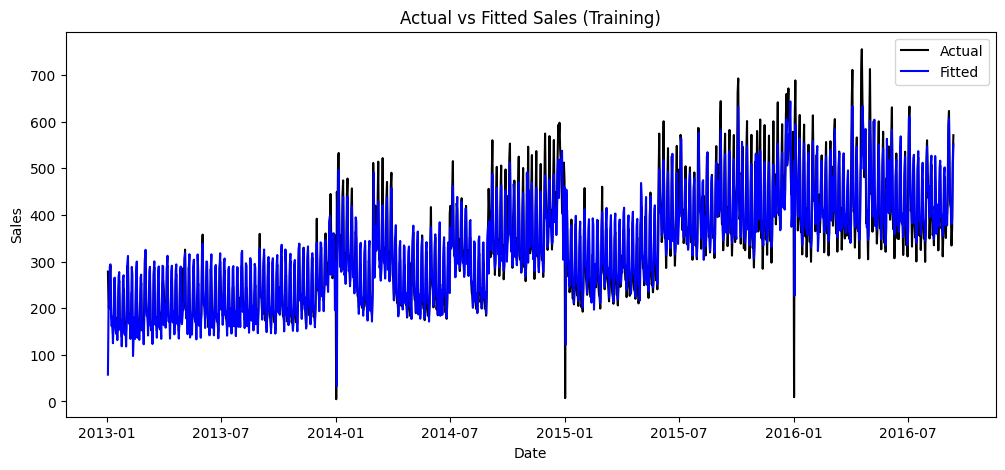

In [7]:
plt.figure(figsize=(12,5))
plt.plot(y_train.index.to_timestamp(), y_train, label='Actual', color='black')
plt.plot(train_pred.index.to_timestamp(), train_pred, label='Fitted', color='blue')
plt.title("Actual vs Fitted Sales (Training)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

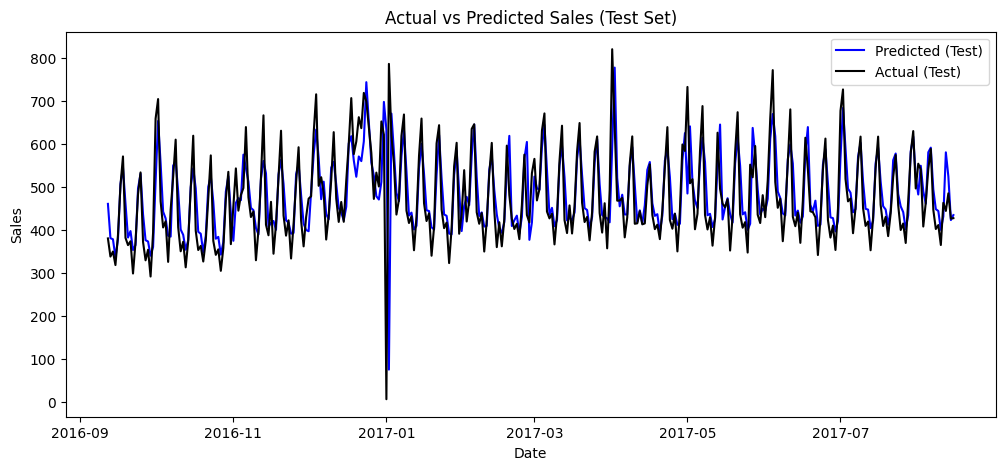

In [8]:
plt.figure(figsize=(12,5))
plt.plot(test_pred.index.to_timestamp(), test_pred, label='Predicted (Test)', color='blue')
plt.plot(y_test.index.to_timestamp(), y_test, label='Actual (Test)', color='black')
plt.title("Actual vs Predicted Sales (Test Set)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

The model performs well as a simple baseline. It captures the weekly seasonal pattern and the long-term trend in sales, which we can see from how closely the predicted line follows the actual line’s shape. However, linear regression smooths out the extreme highs and lows, so it doesn’t fully capture holiday spikes or sudden changes. Overall, it gives a reasonable first approximation, and we can improve it by adding more features or using more advanced time-series models.

**Summary** 

We built a basic time-series forecasting model using linear regression to predict average daily sales from the Store Sales dataset. We first loaded and cleaned the data, then created three kinds of features that time-series models commonly use: a time index to capture overall trends, a lag-1 feature to use the previous day’s sales as a predictor, and day-of-week dummy variables to account for weekly patterns. After creating these features, we trained a linear regression model on the training period and used it to generate predictions for the test period. We evaluated the model using MAE and RMSE, which showed average errors of about 33–54 units, meaning the model follows the general pattern of sales but still has noticeable day-to-day deviations. The fitted-vs-actual plot on the training data shows that the model captures the long-term upward trend and weekly cycles, while the test-set forecast demonstrates how the model projects future sales based on the recent past. Overall, this assignment demonstrated how simple feature engineering and linear regression can be used to make baseline forecasts for time-series data.